### Solubility Prediction using Molecular Descriptors with RDKit

In [1]:
import os, math
import pandas as pd
import numpy as np

import rdkit
import deepchem as dc

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Dataset/raw/solubility-dataset.csv")

In [3]:
# Is soluble if logS > math.log10(200 * 1e-6)
df["isSoluble"] = (df.Solubility > math.log10(200*1e-6)).astype(int)

#### RDKit molecular descriptors based features

- Use DeepChem featurizer with RDKitDescriptors
- Generates 208 features with both use_fragment and ipc_avg
- Here, we generate 123 different descriptors in total for evey molecules

In [14]:
# DeepChem RDKit descriptors
rdkit_featurizer = dc.feat.RDKitDescriptors(use_fragment=False, ipc_avg=False)
features = rdkit_featurizer(df.SMILES) # with one molecule

In [15]:
features.shape

(9982, 123)

In [17]:
# Creating the feature dataset

column_names = rdkit_featurizer.descriptors

df0 = pd.DataFrame(data=features)
df0.columns = column_names

# adding molecule ids and solubility columns
df0.insert(0, "ID", df.ID)
df0["Solubility"] = df.Solubility
df0["isSoluble"] = df.isSoluble

In [18]:
df0.columns

Index(['ID', 'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt',
       'NumValenceElectrons',
       ...
       'NumHeteroatoms', 'NumRotatableBonds', 'NumSaturatedCarbocycles',
       'NumSaturatedHeterocycles', 'NumSaturatedRings', 'RingCount', 'MolLogP',
       'MolMR', 'Solubility', 'isSoluble'],
      dtype='object', length=126)

In [23]:
df0.head()

,ID,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,Solubility,isSoluble
0,A-3,2.296832,0.000000,2.296832,0.000000,0.259676,392.510,346.142,391.281363,142.0,...,2.0,17.0,0.0,0.0,0.0,0.0,3.9581,102.4454,-3.616127,1
1,A-4,11.435093,0.006296,11.435093,0.006296,0.644215,169.183,162.127,169.052764,62.0,...,2.0,0.0,0.0,0.0,0.0,3.0,2.4055,51.9012,-3.254767,1
2,A-5,10.074698,0.652222,10.074698,0.652222,0.546650,140.569,135.529,140.002892,46.0,...,2.0,1.0,0.0,0.0,0.0,1.0,2.1525,36.8395,-2.177078,1
3,A-8,11.573312,-1.369330,11.573312,0.000000,0.136407,756.226,713.890,754.227281,264.0,...,7.0,10.0,0.0,0.0,0.0,6.0,8.1161,200.7106,-3.924409,0
4,A-9,5.440876,0.383760,5.440876,0.383760,0.490100,422.525,392.285,422.220557,164.0,...,6.0,12.0,0.0,4.0,4.0,6.0,2.4854,119.0760,-4.662065,0


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error
import lightgbm as lgb
from lightgbm import Dataset
# from utils file
from utils import plot_confusion_matrix, draw_roc_curve

In [77]:
# training data
y = df0.isSoluble
X = df0.drop(columns=["ID", "Solubility", "isSoluble"])

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [79]:
train_data = Dataset(X_train, label=y_train)
test_data = Dataset(X_test, label=y_test)

In [80]:
params = {
            "objective": "binary",
            "is_unbalance": "true",
            "boosting_type": "dart",
            "bagging_ratio": 0.6,
            "feature_fraction": 0.6,
            "metric": ["auc"],
        }

In [81]:
# training a LightGBM model
model = lgb.train(params=params,
                 train_set=train_data,
                 valid_sets=[test_data, train_data],
                  num_boost_round=1200,
                  verbose_eval=100
                 )

[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Info] Number of positive: 5650, number of negative: 2834
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23506
[LightGBM] [Info] Number of data points in the train set: 8484, number of used features: 121
[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.665959 -> initscore=0.689966
[LightGBM] [Info] Start training from score 0.689966
[100]	training's auc: 0.989408	valid_0's auc: 0.973171
[200]	training's auc: 0.996008	valid_0's auc: 0.974912
[300]	training's auc: 0.998886	valid_0's auc: 0.975681
[400]	training's auc: 0.999695	valid_0's auc: 0.976854
[500]	training's auc: 0.999952	valid_0's auc: 0.977098
[600]	training's auc: 0.999984	valid_0's auc: 0.976826
[700]	training

In [82]:
y_proba = model.predict(X_test)

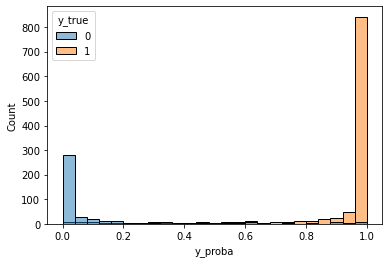

In [83]:
tmp = pd.DataFrame(data={"y_true":  y_test, "y_proba": y_proba})
sns.histplot(x="y_proba", hue="y_true", data=tmp, bins=25);

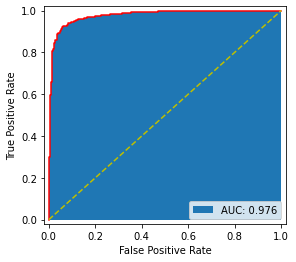

In [92]:
draw_roc_curve(y_test, y_proba)

In [84]:
y_pred = (y_proba > 0.5).astype(int)

In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       435
           1       0.96      0.94      0.95      1063

    accuracy                           0.93      1498
   macro avg       0.91      0.92      0.92      1498
weighted avg       0.93      0.93      0.93      1498



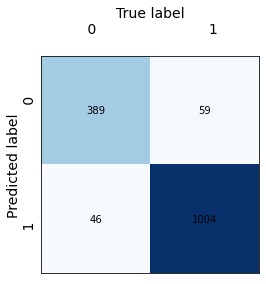

In [90]:
# confusion matrix
plot_confusion_matrix(y_test, y_pred)

### Regression Model

- Regression model to predict the solubility in LogS scale

In [52]:
y = df0.Solubility
X = df0.drop(columns=["ID", "Solubility", "isSoluble"])

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

In [54]:
train_data = Dataset(X_train, label=y_train)
test_data = Dataset(X_test, label=y_test)

In [55]:
params = {
            "objective": "regression",
            "is_unbalance": "true",
            "boosting_type": "dart",
            "bagging_ratio": 0.6,
            "feature_fraction": 0.6,
            "metric": ["mse"],
        }

In [56]:
model = lgb.train(params=params,
                 train_set=train_data,
                 valid_sets=[test_data, train_data],
                  num_boost_round=1200,
                  verbose_eval=100
                 )

[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23569
[LightGBM] [Info] Number of data points in the train set: 8484, number of used features: 121
[LightGBM] [Warning] Unknown parameter: bagging_ratio
[LightGBM] [Info] Start training from score -2.882983
[100]	training's l2: 0.911509	valid_0's l2: 1.31921
[200]	training's l2: 0.629966	valid_0's l2: 1.12976
[300]	training's l2: 0.48399	valid_0's l2: 1.07821
[400]	training's l2: 0.385419	valid_0's l2: 1.03844
[500]	training's l2: 0.315071	valid_0's l2: 1.01301
[600]	training's l2: 0.301533	valid_0's l2: 1.01059
[700]	training's l2: 0.255276	valid_0's l2: 1.00273
[800]	training's l2: 0.236421	valid_0's l2: 0.994131
[900]	training's l2: 0.20532	valid_0's l2: 0.989956
[1000]	training's l2: 0

In [57]:
y_proba = model.predict(X_test)

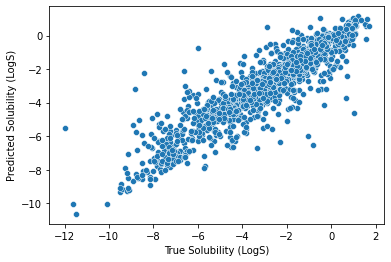

In [62]:
tmp = pd.DataFrame(data={"y_true":  y_test, "y_proba": y_proba})
sns.scatterplot(x="y_true", y="y_proba", data=tmp);
plt.xlabel("True Solubility (LogS)")
plt.ylabel("Predicted Solubility (LogS)");

In [75]:
mean_squared_error(y_test, y_proba), mean_absolute_error(y_test, y_proba)

(0.9859244030790442, 0.6616740158182908)